In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('C:/Users/92sjy/deep-learning/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/Users/92sjy/deep-learning/input\mitbih_test.csv
C:/Users/92sjy/deep-learning/input\mitbih_train.csv


In [2]:
train = pd.read_csv('C:/Users/92sjy/deep-learning/input/mitbih_train.csv',header=None)
test = pd.read_csv('C:/Users/92sjy/deep-learning/input/mitbih_test.csv',header=None)

In [3]:
print(train.shape)
print(test.shape)

(87554, 188)
(21892, 188)


In [4]:
print(train[187].value_counts())

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64


In [5]:
train = pd.concat([train, test], axis=0)

In [6]:
print(train[187].value_counts())

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: 187, dtype: int64


In [7]:
train_target = train[187]
label= 187

df = train.groupby(label, group_keys=False)
train = pd.DataFrame(df.apply(lambda x: x.sample(df.size().min()))).reset_index(drop=True)

In [8]:
print(train[187].value_counts())

4.0    803
3.0    803
2.0    803
1.0    803
0.0    803
Name: 187, dtype: int64


In [9]:
train.shape

(4015, 188)

In [10]:
train = train.sample(frac=1)

In [11]:
from keras.utils import to_categorical

print("--- X ---")
X = train.loc[:, train.columns != 187]
print(X.head())
print(X.info())

print("--- Y ---")
y = train.loc[:, train.columns == 187]
y = to_categorical(y)

print("--- testX ---")
testX = test.loc[:, test.columns != 187]
print(testX.head())
print(testX.info())

print("--- testy ---")
testy = test.loc[:, test.columns == 187]
testy = to_categorical(testy)

Using TensorFlow backend.


--- X ---
           0         1         2         3         4         5         6    \
2954  1.000000  0.824468  0.297872  0.147163  0.106383  0.106383  0.081560   
1410  0.982120  1.000000  0.841635  0.596424  0.553001  0.572158  0.544061   
3234  0.816109  0.721884  0.621581  0.484802  0.358663  0.220365  0.159574   
900   0.862348  0.769231  0.210526  0.016194  0.072874  0.121457  0.125506   
1101  1.000000  0.754717  0.081761  0.059748  0.116352  0.135220  0.135220   

           7         8         9    ...  177  178  179  180  181  182  183  \
2954  0.085106  0.076241  0.081560  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1410  0.535121  0.540230  0.535121  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3234  0.110942  0.117021  0.138298  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
900   0.165992  0.214575  0.178138  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1101  0.132075  0.113208  0.132075  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      184  185  186  
2954  0.0  0.0  0.0  
1410  0.

In [12]:
X.shape

(4015, 187)

In [13]:
y.shape

(4015, 5)

In [14]:
X = np.expand_dims(X,2)
testX = np.expand_dims(testX,2)
X.shape

(4015, 187, 1)

In [15]:
from keras import backend as K
    
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
 
    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Input, Flatten, SeparableConv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model

from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [17]:
n_obs, feature, depth = X.shape
batch_size = 16

In [18]:
def get_model_cnn():
    input_img = Input(shape=(feature, depth), name='ImageInput')
    x = Conv1D(64, 3, activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv1D(64, 3, activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling1D(2, name='pool1')(x)
    
    x = SeparableConv1D(64, 3, activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv1D(64, 3, activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling1D(2, name='pool2')(x)
    
    x = SeparableConv1D(128, 3, activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    
    x = SeparableConv1D(256, 3, activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling1D(2, name='pool3')(x)
    x = Dropout(0.6, name='dropout0')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='dropout1')(x)
    x = Dense(128, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(5, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    model.summary()
    return model

In [19]:
model =  get_model_cnn()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc',f1])
history = model.fit(X, y, validation_split=0.1,epochs=50,batch_size=batch_size,shuffle=True,class_weight='auto')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 187, 1)            0         
_________________________________________________________________
Conv1_1 (Conv1D)             (None, 187, 64)           256       
_________________________________________________________________
Conv1_2 (Conv1D)             (None, 187, 64)           12352     
_________________________________________________________________
pool1 (MaxPooling1D)         (None, 93, 64)            0         
_________________________________________________________________
Conv2_1 (SeparableConv1D)    (None, 93, 64)            4352      
_________________________________________________________________
Conv2_2 (SeparableConv1D)    (None, 93, 64)            4352      
__________

In [20]:
print("Evaluation: ")
mse, acc, F1 = model.evaluate(testX, testy)
print('mean_squared_error :', mse)
print('accuracy:', acc)
print('F1:', F1)

Evaluation: 
21892/21892 [==============================] - 2s 93us/step
mean_squared_error : 0.41508005971556916
accuracy: 0.8761191302758998
F1: 0.8759221470423509


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

Accuracy: 87.61%


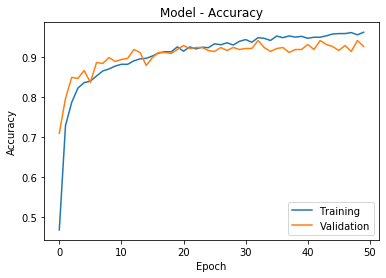

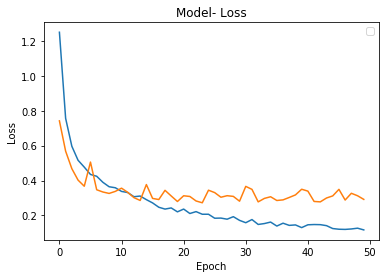

In [22]:
evaluate_model(history,testX,testy,model)
y_pred=model.predict(testX)

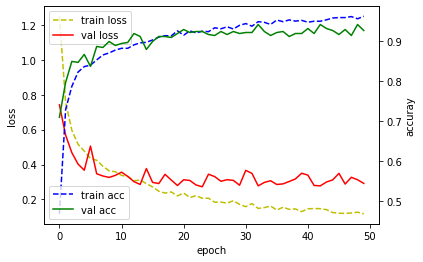

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()


acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y--', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
acc_ax.plot(history.history['acc'], 'b--', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left', fontsize='10')
acc_ax.legend(loc='lower left', fontsize='10')

fig.set_size_inches(6, 4)
plt.grid(False)
plt.show()


#train_loss(노란색) : 훈련 손실값이며 x축은 에포크 수, 좌측 y축은 손실값을 나타냅니다.
#val_loss(빨간색) : 검증 손실값이며 x축은 에포크 수, 좌측 y축은 손실값을 나타냅니다.
#train_acc(파란색) : 훈련 정확도이며 x축은 에포크 수, 우측 y축은 정확도를 나타냅니다.
#val_acc(녹색) : 검증 정확도이며 x축은 에포크 수, 우측 y축은 정확도를 나타냅니다.

Normalized confusion matrix


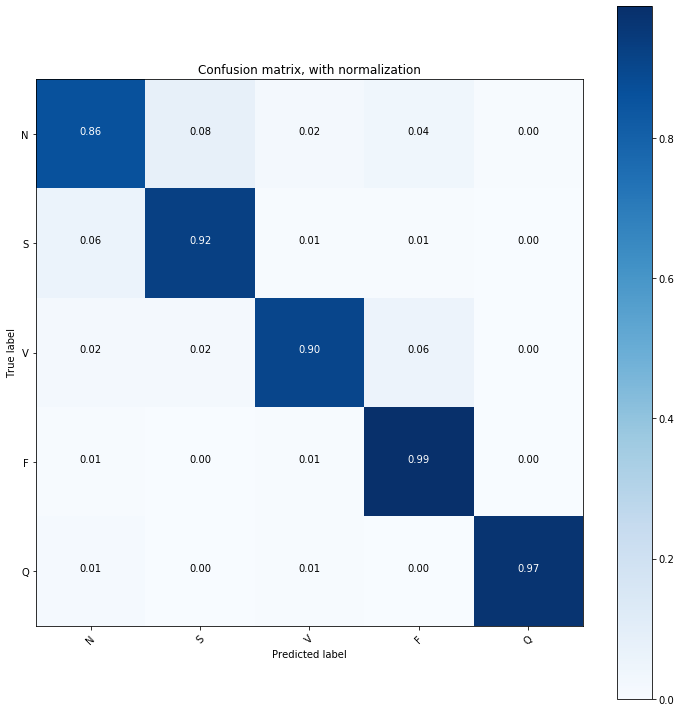

In [24]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(testy.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

Saved model to disk
